# Adversary Noise
by Gaetano Bonofiglio, Veronica Iovinella

## Introduction
We previously created various Convolutional Neural Networks using $TensorFlow$ with various degrees of success. In this notebook we'll find a so-called "**adversarial example**" for a state-of-the-art neural network (**Inception Model V3**) that will cause a mis-classification of an input image of any class. The *adversary noise* is added to a correctly classified picture and can't be perceived by a human eye, but it's catastrophic for the classifier.

Usually to win against an adversary example it's needed to re-train a CNN in a never-ending cycle (it's always possible to find a new adversary example for the newly trained CNN, expecially if it is open source). We will instead explore a different method for solving this issue that doesn't involve re-training the network and should be able to win even against ad-hoc noises. 

## Flowchart
To find the adversary examples, we follow the flowchart below. 
We start from an image given to Inception Model, we take the output of the unscaled softmax layer and give it as an input to a cross-entropy loss-function, together with a target class. This new function then calculates the cross-entropy to generate a noise that, added to the original image, gets an output that is closer, iteration by iteration, to the target class. 

TODO

In [1]:
from IPython.display import Image, display

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from adversary import Adversary
adv = Adversary()

import inception

tf.__version__

'0.11.head'

In [3]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


In [4]:
# Load the Inception model so it is ready for classifying images.
model = inception.Inception()
# Helper-function for classifying and plotting images
def classify(image_path):
    display(Image(image_path))
    pred = model.classify(image_path=image_path)
    model.print_scores(pred=pred, k=10, only_first_name=True)
# Image path for the example picture to classify
image_path = os.path.join(inception.data_dir, 'cropped_panda.jpg')

We now try to classify the image of a panda to see if everything is working fine.

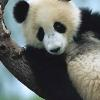

88.49% : giant panda
 0.88% : indri
 0.32% : lesser panda
 0.15% : custard apple
 0.13% : earthstar
 0.09% : sea urchin
 0.06% : gibbon
 0.05% : forklift
 0.05% : digital watch
 0.05% : go-kart


In [5]:
classify(image_path)

### Get Input and Output for the Inception Model
We need to get a reference to the input tensor for the Inception model. This is because the input tensor is for the resized image, and we want to add noise to the resized image and feed the result back into the graph, in order to be sure that the noise is not processed further by the resizing algorithm.

We also need to reference the unscaled output of the softmax-classifier for the Inception model (often called 'logits'). The logits are necessary because we will add a new loss-function to the graph, which requires these unscaled outputs.

In [6]:
resized_image = model.resized_image

# Reference to the output of the softmax-classifier for the Inception model
y_pred = model.y_pred
# Reference the unscaled output of the softmax-classifier - logits
y_logits = model.y_logits

### New loss-function
Here it is the new loss-function. We also need the gradient of this loss-function with regard to the input image. 

In [7]:
with model.graph.as_default():
    # Add a placeholder variable for the target class-number
    # This will be set to e.g. 300 for the 'bookcase' class
    pl_cls_target = tf.placeholder(dtype=tf.int32)

    # New cross-entropy loss-function
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits, labels=[pl_cls_target])

    gradient = tf.gradients(loss, resized_image)

## TensorFlow Session

In [8]:
session = tf.Session(graph=model.graph)

## Finding Adversary Noise
This function finds the noise that must be added to the given input image to be classified as the desired target-class, so to be mis-classified.

This is obtained by doing an optimization with gradient descent. The noise is initialized to zero and then iteratively updated using the gradient of the loss-function, bringing the classification closer and closer to the target-class. The optimization terminates when the target-classification is reached with the required score (by default 99%), or when the max number of iterations have been performed (by default 100).

At the end the original image, the image with the added noise and the noise itself are plotted.

In [9]:
def adversary_example(image_path, cls_target,
                      noise_limit=3.0, required_score=0.99):
    adv.adversary_example(session, y_pred, resized_image, model, gradient, pl_cls_target, 
                          image_path, cls_target,
                          noise_limit, required_score)

## Results
As shown below, we can see from some examples that a few iterations are sufficient to calculate the noise, resulting in a misclassification of arbitrary score (in this case 99%).

Iteration: 0
Source score:  61.52%, class-number:  125, class-name: golden retriever
Target score:   0.01%, class-number:  220, class-name: umbrella
Gradient min: -0.001715, max:  0.001959, stepsize:   3572.60

Iteration: 1
Source score:   0.48%, class-number:  125, class-name: golden retriever
Target score:   0.04%, class-number:  220, class-name: umbrella
Gradient min: -0.003461, max:  0.003100, stepsize:   2022.35

Iteration: 2
Source score:   4.10%, class-number:  125, class-name: golden retriever
Target score:   0.36%, class-number:  220, class-name: umbrella
Gradient min: -0.004149, max:  0.002682, stepsize:   1687.32

Iteration: 3
Source score:   2.75%, class-number:  125, class-name: golden retriever
Target score:  13.21%, class-number:  220, class-name: umbrella
Gradient min: -0.005081, max:  0.004361, stepsize:   1377.74

Iteration: 4
Source score:   3.42%, class-number:  125, class-name: golden retriever
Target score:  57.37%, class-number:  220, class-name: umbrella
Gradien

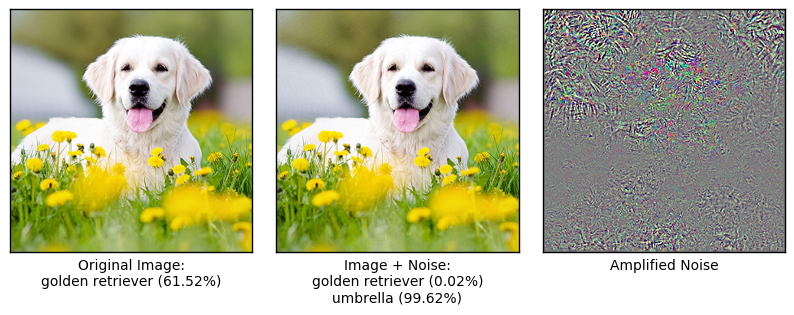

Noise min: -3.000, max: 3.000, mean: 0.001, std: 0.743


In [10]:
image_path = "imagesForClassification/dog.jpg"
adversary_example(image_path=image_path, cls_target=220)

Iteration: 0
Source score:  47.47%, class-number:   10, class-name: Persian cat
Target score:   0.06%, class-number:  535, class-name: sunglasses
Gradient min: -0.001900, max:  0.002446, stepsize:   2861.93

Iteration: 1
Source score:   0.41%, class-number:   10, class-name: Persian cat
Target score:   0.42%, class-number:  535, class-name: sunglasses
Gradient min: -0.001881, max:  0.001840, stepsize:   3720.97

Iteration: 2
Source score:   0.72%, class-number:   10, class-name: Persian cat
Target score:   1.83%, class-number:  535, class-name: sunglasses
Gradient min: -0.002028, max:  0.001701, stepsize:   3452.34

Iteration: 3
Source score:   0.44%, class-number:   10, class-name: Persian cat
Target score:  18.21%, class-number:  535, class-name: sunglasses
Gradient min: -0.002366, max:  0.002182, stepsize:   2958.83

Iteration: 4
Source score:   0.08%, class-number:   10, class-name: Persian cat
Target score:  43.49%, class-number:  535, class-name: sunglasses
Gradient min: -0.00344

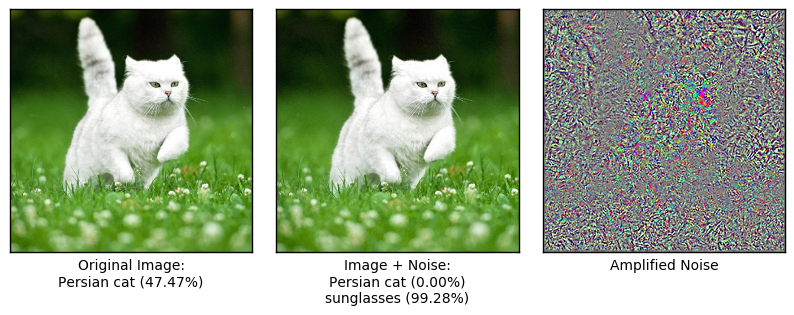

Noise min: -3.000, max: 3.000, mean: 0.000, std: 1.070


In [11]:
image_path = "imagesForClassification/cat.jpg"
adversary_example(image_path=image_path, cls_target=535)

Iteration: 0
Source score:  87.96%, class-number:  318, class-name: Granny Smith
Target score:   0.00%, class-number:   22, class-name: killer whale
Gradient min: -0.001250, max:  0.001410, stepsize:   4963.31

Iteration: 1
Source score:   1.68%, class-number:  318, class-name: Granny Smith
Target score:   0.04%, class-number:   22, class-name: killer whale
Gradient min: -0.001285, max:  0.001185, stepsize:   5445.68

Iteration: 2
Source score:  13.32%, class-number:  318, class-name: Granny Smith
Target score:   0.04%, class-number:   22, class-name: killer whale
Gradient min: -0.001314, max:  0.000983, stepsize:   5328.46

Iteration: 3
Source score:  11.44%, class-number:  318, class-name: Granny Smith
Target score:   0.12%, class-number:   22, class-name: killer whale
Gradient min: -0.001152, max:  0.000819, stepsize:   6074.28

Iteration: 4
Source score:   1.63%, class-number:  318, class-name: Granny Smith
Target score:   0.25%, class-number:   22, class-name: killer whale
Gradien

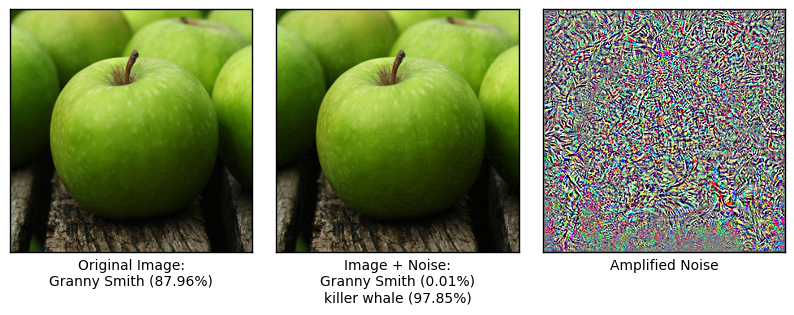

Noise min: -3.000, max: 3.000, mean: 0.006, std: 1.506


In [12]:
image_path = "imagesForClassification/grannySmith.jpg"
adversary_example(image_path=image_path, cls_target=22, noise_limit=3.0, required_score=0.95)

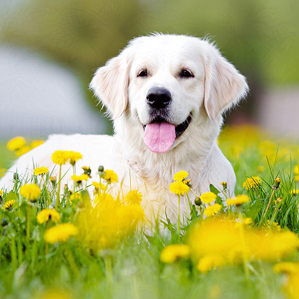

98.73% : umbrella
 0.24% : Great Pyrenees
 0.06% : golden retriever
 0.05% : kuvasz
 0.02% : flat-coated retriever
 0.01% : Labrador retriever
 0.01% : rapeseed
 0.01% : Leonberg
 0.01% : clumber
 0.01% : water jug


In [13]:
classify("adversaryImages/golden-retriever.jpg")